In [19]:
# -----------------------------
# Cell 1: Setup paths
# -----------------------------
import sys
from pathlib import Path

# Notebook location
notebook_path = Path().resolve()  # current notebook folder
project_root = notebook_path.parent.parent  # Notebook/ -> project root
src_path = project_root / "src"


# Current notebook folder
notebook_path = Path().resolve()


# Add to Python path
sys.path.insert(0, str(src_path))
sys.path.insert(0, str(project_root))

print("Notebook path:", notebook_path)
print("Project root:", project_root)
print("SRC path:", src_path)

Notebook path: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\notebooks\analysis
Project root: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics
SRC path: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\src


In [20]:
# Basic imports
import pandas as pd
import logging

# Project modules
from fintech_app_reviews.config import load_config
from fintech_app_reviews.nlp.sentiment import annotate_dataframe, aggregate_sentiment
from fintech_app_reviews.nlp.keywords import extract_tfidf_keywords_per_group, attach_top_keywords_to_df, preprocess_text
from fintech_app_reviews.nlp.themes import compile_keyword_patterns, rule_assign_themes
from fintech_app_reviews.nlp.sentiment_bert import annotate_dataframe_parallel
from fintech_app_reviews.viz.plots import plot_sentiment_distribution, plot_sentiment_by_group, plot_theme_counts
# Logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s %(message)s")
logger = logging.getLogger(__name__)

In [21]:
# Config path at project root
config_path = project_root / "configs" / "nlp.yaml"

# Load NLP config
nlp_cfg = load_config(config_path)

print("Config path:", config_path)

# Load cleaned reviews
df = pd.read_csv(project_root / "data/interim/clean_reviews.csv")
print(f"Loaded {len(df)} reviews")
df.head()

Config path: D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\configs\nlp.yaml
Loaded 1374 reviews


,review,rating,date,bank,source
0,it's special for me,5,2025-11-29,Commercial Bank of Ethiopia (CBE),google_play
1,this application is very important and advanta...,5,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play
2,why didn't work this app?,1,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play
3,the app makes our life easier. thank you cbe!,5,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play
4,the most advanced app. but how to stay safe?,5,2025-11-27,Commercial Bank of Ethiopia (CBE),google_play


In [22]:
# -------------------------
# Clean text
# -------------------------
df["txt_clean"] = df["review"].apply(preprocess_text)

df[["review", "txt_clean"]].head()


,review,txt_clean
0,it's special for me,special
1,this application is very important and advanta...,application very important advantage transfer ...
2,why didn't work this app?,why didn work app
3,the app makes our life easier. thank you cbe!,app makes life easier thank you cbe
4,the most advanced app. but how to stay safe?,most advanced app but how stay safe


In [29]:
# Extract manual rules from YAML
theme_rules = nlp_cfg["themes"].get("rules", [])

# Build a dict like theme_map
theme_map = {rule["name"]: rule["keywords"] for rule in theme_rules}

compiled_map = compile_keyword_patterns(theme_map)

logger.info("Compiled theme patterns from YAML")

INFO:__main__:Compiled theme patterns from YAML


In [24]:
# -------------------------
# Extract TF-IDF keywords per bank
# -------------------------
top_keywords_dict = extract_tfidf_keywords_per_group(
    df,
    text_col="txt_clean",
    group_col="bank",
    top_n=50
)

# Flatten keywords
global_tfidf = sum(top_keywords_dict.values(), [])

df = attach_top_keywords_to_df(
    df,
    text_col="txt_clean",
    global_tfidf=global_tfidf
)

df[["review", "keywords"]].head()

,review,keywords
0,it's special for me,
1,this application is very important and advanta...,very|very|very|money|money
2,why didn't work this app?,app|why|app|why|app
3,the app makes our life easier. thank you cbe!,thank you|app|you|app|cbe
4,the most advanced app. but how to stay safe?,app but|app|but|app|but


In [25]:
def safe_assign_themes(text: str, compiled_map=compiled_map):
    """Assign themes to a review using compiled regex patterns."""
    if not text:
        return []
    return rule_assign_themes(text, compiled_map)


df["themes"] = df["txt_clean"].apply(safe_assign_themes)

# Get output path from config
theme_path = project_root / \
    nlp_cfg["output"].get(
        "themes_path")

# Save theme results
df.to_csv(theme_path, index=False)
logger.info("Saved theme results to %s", theme_path)
logger.info("Saved theme results to %s", theme_path)

INFO:__main__:Saved theme results to D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\data\processed\reviews_with_themes.csv
INFO:__main__:Saved theme results to D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\data\processed\reviews_with_themes.csv


In [26]:
# -------------------------
# Annotate sentiment using BERT (parallel)
# -------------------------
df = annotate_dataframe_parallel(df, text_col="txt_clean")

df[["review", "sentiment_label", "sentiment_score"]].head()

# Get output path from config
sentiment_path = project_root / \
    nlp_cfg["output"].get(
        "sentiment_path")

df.to_csv(sentiment_path, index=False)
logger.info("Saved sentiment results to %s", sentiment_path)

Device set to use cpu
INFO:__main__:Saved sentiment results to D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\data\processed\reviews_with_sentiment.csv


In [27]:
# -------------------------
# Aggregate sentiment per bank/rating
# -------------------------
agg_df = aggregate_sentiment(df, group_cols=["bank", "rating"])

enriched_output_path = project_root / \
    nlp_cfg["output"].get(
        "enriched_output_path")

df.to_csv(enriched_output_path, index=False)
logger.info("Saved aggregated sentiment results to %s", enriched_output_path)
agg_df.head()

INFO:__main__:Saved aggregated sentiment results to D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\data\processed\nlp_enriched_reviews.csv


,bank,rating,mean_sentiment_score,positive_count,negative_count,neutral_count
0,Bank of Abyssinia (BOA),1,-0.753650,27,193,0
1,Bank of Abyssinia (BOA),2,-0.668315,4,21,0
2,Bank of Abyssinia (BOA),3,-0.081944,15,18,0
3,Bank of Abyssinia (BOA),4,0.126729,13,10,0
4,Bank of Abyssinia (BOA),5,0.558964,143,42,0


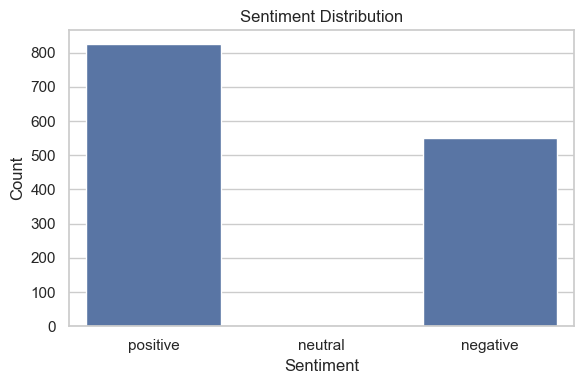

D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\src\fintech_app_reviews\viz\plots.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


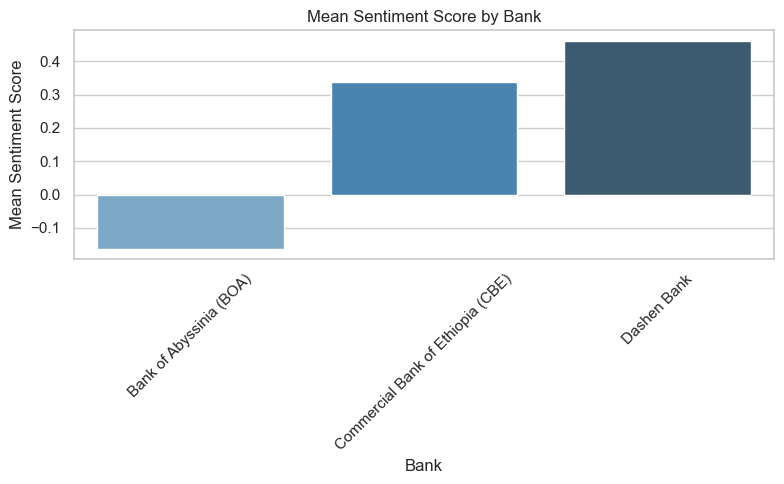

D:\10Acadamy\Week 2\Tasks\Fintech-App-Customer-Experience-Analytics\src\fintech_app_reviews\viz\plots.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


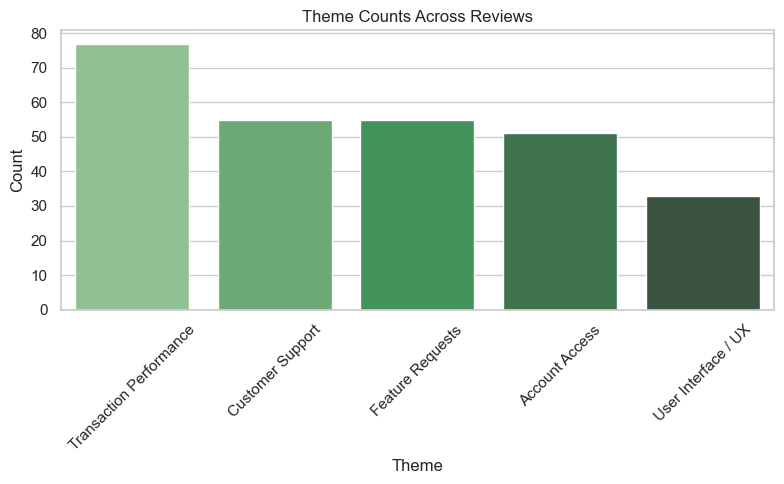

In [28]:
# Plot sentiment distribution
plot_sentiment_distribution(df, sentiment_col="sentiment_label")

# Plot mean sentiment per bank
plot_sentiment_by_group(df, group_col="bank",
                        sentiment_score_col="sentiment_score")

# Plot theme counts
plot_theme_counts(df, theme_col="themes")